In [3]:
import cv2.cv2 as cv2
import keras
import numpy as np

from model.colorunet import ColorUNet, smoothL1
from preprocessing import inference_prepro, resize_keep_aspect_ratio, zero_padd, find_input_size, preprocessing
from postprocessing import postprocess
from keras_unet.models import custom_unet

from keras.utils import plot_model
import os
os.environ["CUDA_VISIBLE_DEVICES"]=""
%matplotlib inline
import matplotlib.pyplot as plt


In [2]:
image_size = (256,256)
model = ColorUNet(input_size=(None, None, 1), large=False)
model = custom_unet(
            input_shape=(None, None, 1),
            use_batch_norm=True,
            num_classes=2,
            upsample_mode='simple',
            filters=64,
            dropout=0.2,
            output_activation='tanh')
model.load_weights('logs/unet_alt_large_256_variable_l2_b8_coco/trained_weights.h5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [3]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, None, None, 1 0                                            
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, None, None, 6 640         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_8 (BatchNor (None, None, None, 6 256         conv2d_16[0][0]                  
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, None, None, 6 0           batch_normalization_8[0][0]      
__________________________________________________________________________________________________
conv2d_17 

(480, 640, 3)
(681, 1024, 3)


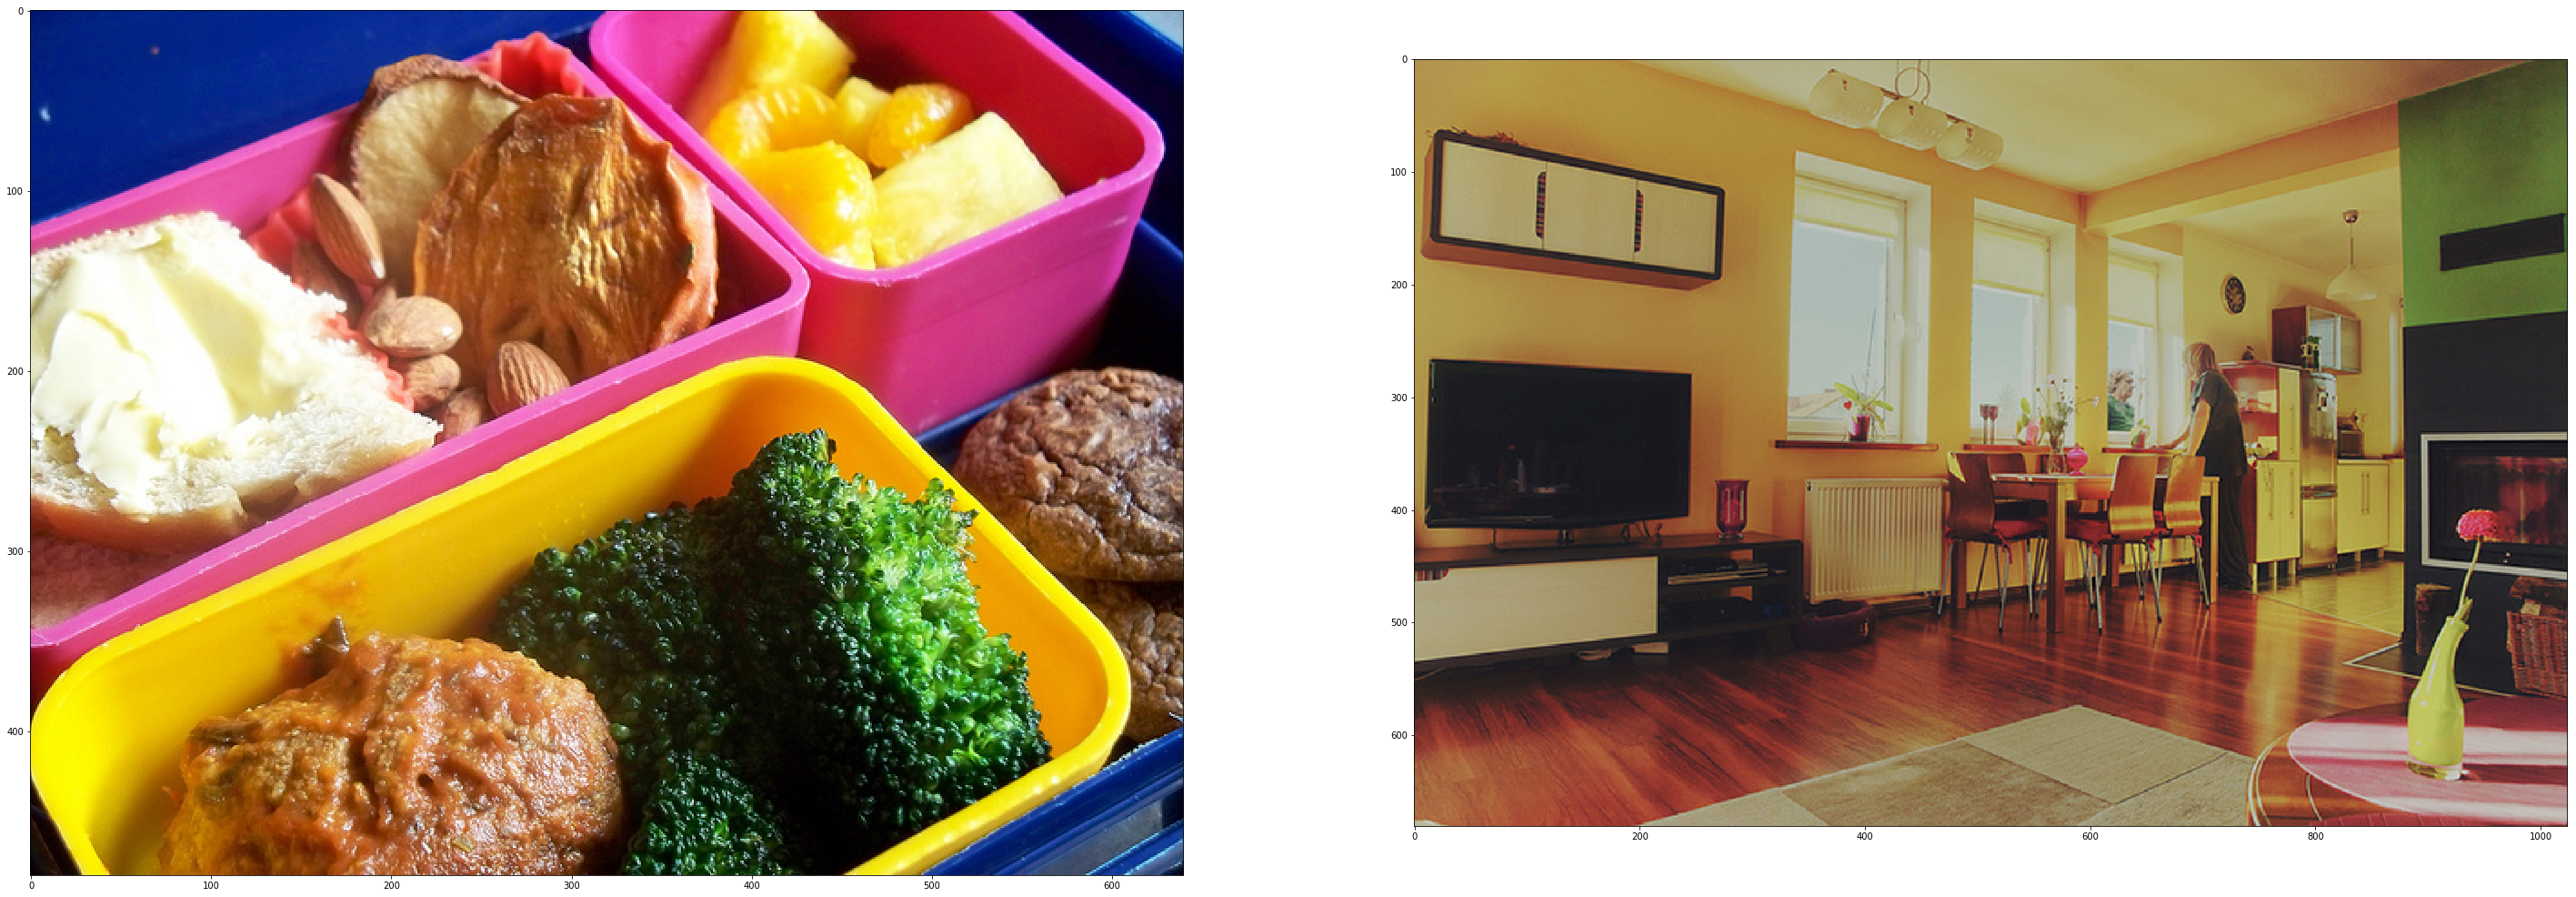

In [18]:
ex_train = cv2.imread('example_from_train.jpg')
ex_train = cv2.cvtColor(ex_train, cv2.COLOR_BGR2RGB)
print(ex_train.shape)
ex_val = cv2.imread('example_from_val.jpg')
ex_val = resize_keep_aspect_ratio(ex_val, (1024,1024))
ex_val = cv2.cvtColor(ex_val, cv2.COLOR_BGR2RGB)

print(ex_val.shape)
f, axarr = plt.subplots(1,2, figsize=(50,100))

axarr[0].imshow(ex_train)
axarr[1].imshow(ex_val)

(480, 640, 3)
(80, 128, 1)


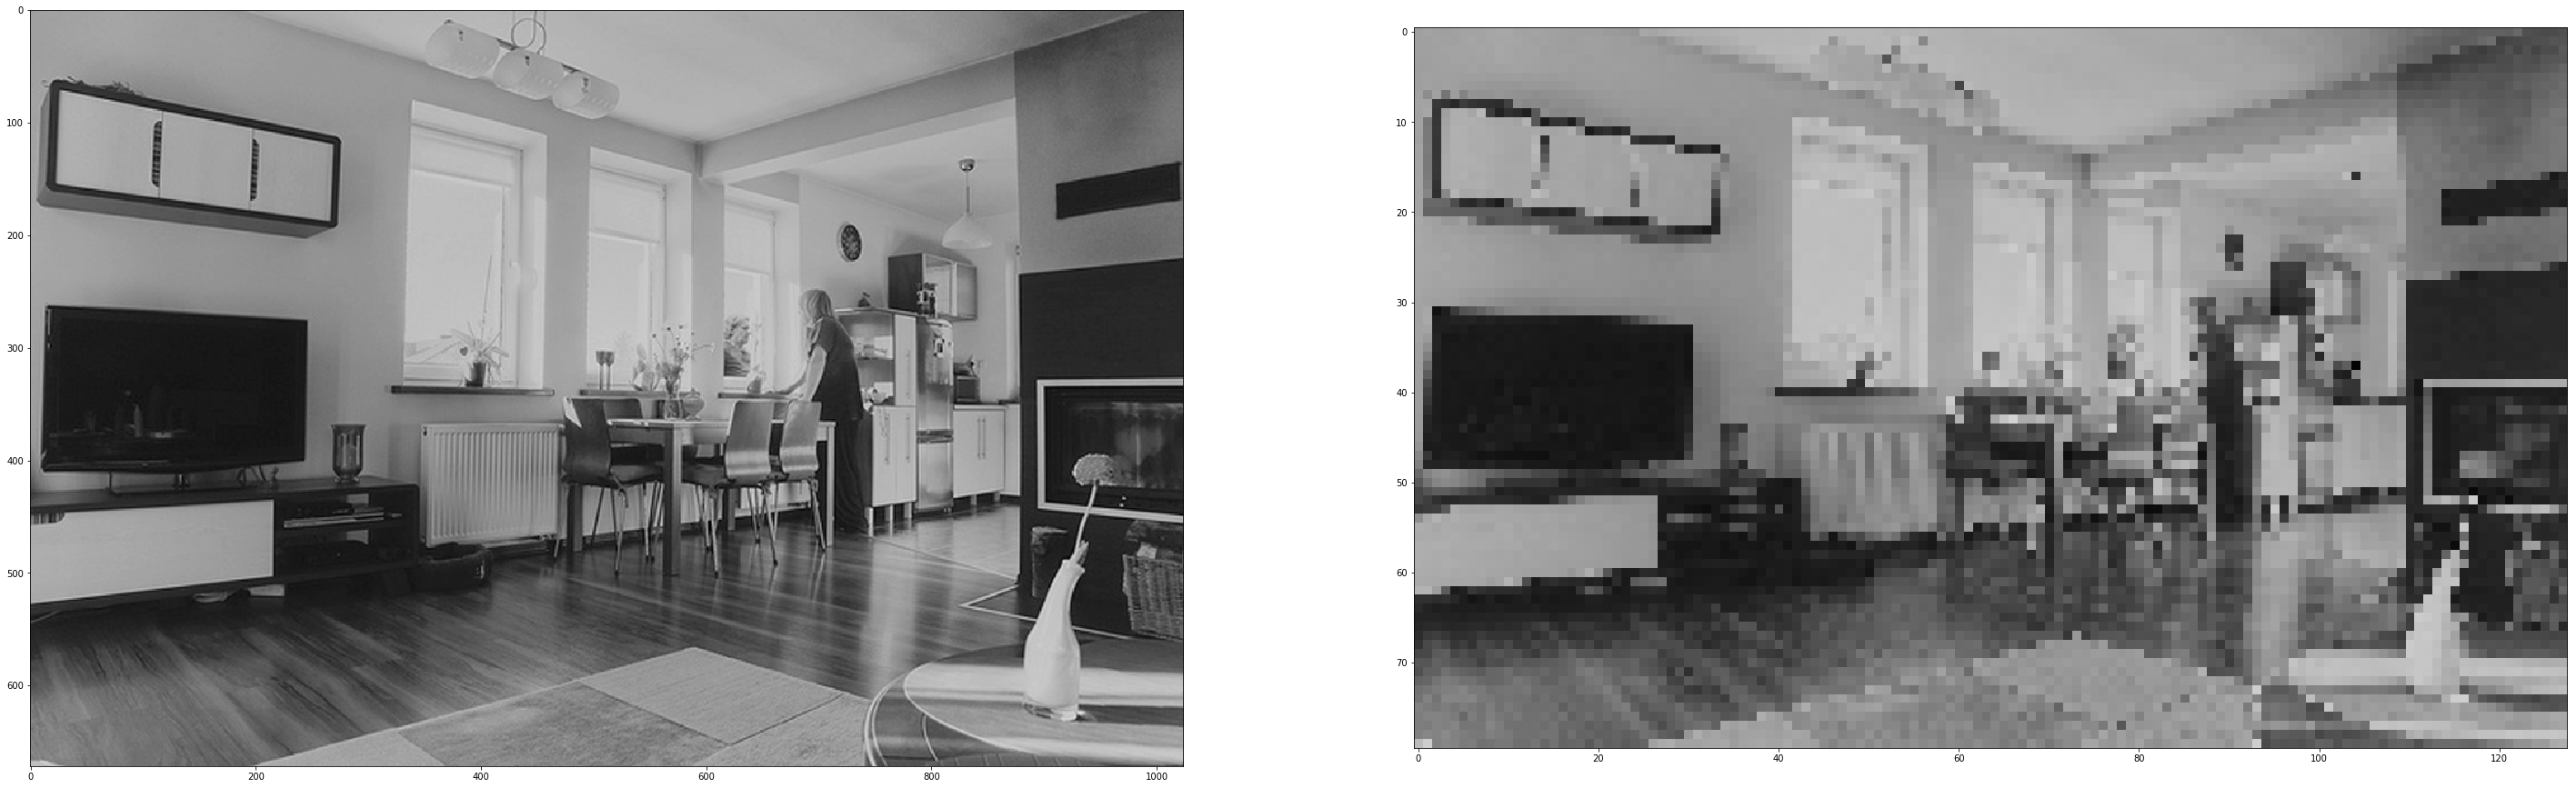

In [19]:
ex_train_gray = inference_prepro(ex_train, find_input_size(ex_train.shape[1], ex_train.shape[0]))
print(ex_train.shape)


ex_val_gray_large = inference_prepro(ex_val, find_input_size(ex_val.shape[1], ex_val.shape[0]))
ex_val_gray = resize_keep_aspect_ratio(ex_val_gray_large, find_input_size(128, 128))
ex_val_gray = inference_prepro(ex_val, find_input_size(ex_val_gray.shape[1], ex_val_gray.shape[0]))
print(ex_val_gray.shape)

f, axarr = plt.subplots(1,2, figsize=(50,100))

axarr[0].imshow(np.squeeze(ex_val_gray_large, -1), cmap='gray', vmin=-1, vmax=1)
axarr[1].imshow(np.squeeze(ex_val_gray, -1), cmap='gray', vmin=-1, vmax=1)

In [20]:
pred_val_large = model.predict(np.expand_dims(ex_val_gray_large, 0))
pred_val_large = np.squeeze(pred_val_large)
pred_val = model.predict(np.expand_dims(ex_val_gray, 0))
pred_val = np.squeeze(pred_val)

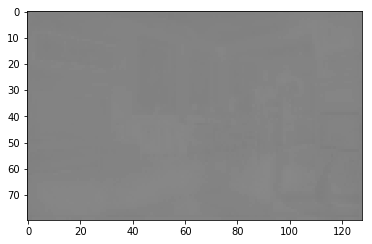

In [21]:
plt.imshow(pred_val[...,0], cmap='gray', vmin=-1, vmax=1)

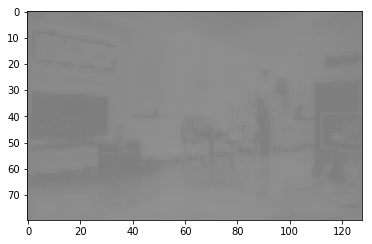

In [22]:
plt.imshow(pred_val[...,1], cmap='gray', vmin=-1, vmax=1)

(672, 1024, 2)
(672, 1024)


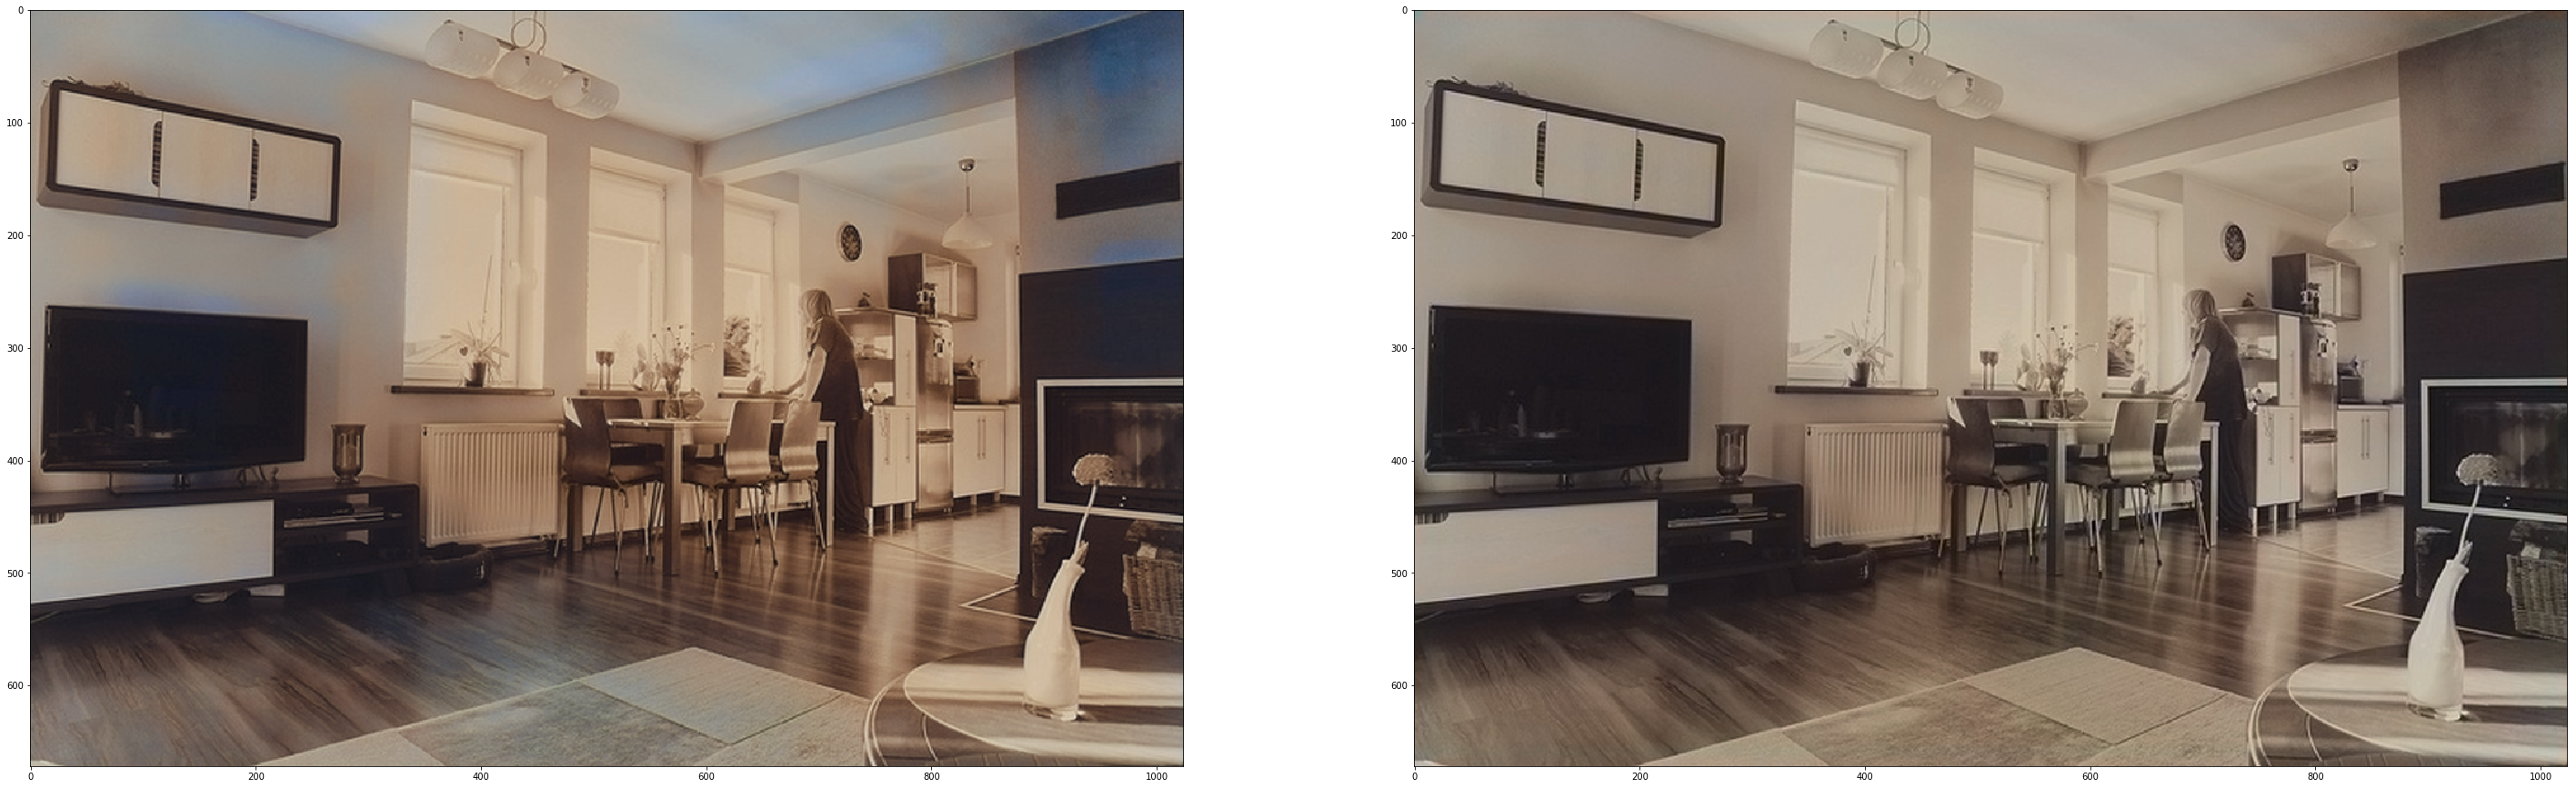

In [23]:
#pred_train = np.squeeze(pred_train)


result_val_large = np.stack([ex_val_gray_large[...,0], pred_val_large[..., 0], pred_val_large[..., 1]], axis=-1)
#result_train = np.stack([ex_train_gray[...,0], pred_train[..., 0], pred_train[..., 1]], axis=-1)


result_val_large += 1.
result_val_large *= 128.
result_val_large = result_val_large.astype('uint8')




pred_val = cv2.resize(pred_val, (ex_val_gray_large.shape[1], ex_val_gray_large.shape[0]), interpolation=cv2.INTER_CUBIC)
print(pred_val.shape)
print(ex_val_gray_large[...,0].shape)

result_val = np.stack([ex_val_gray_large[...,0], pred_val[..., 0], pred_val[..., 1]], axis=-1)

result_val += 1.
result_val *= 128.
result_val = result_val.astype('uint8')



#idea = np.ones((pred.shape[0],pred.shape[1]) + (2,))
#idea += 128.0
#result2 = np.stack([result[...,0], idea[...,0], idea[...,1]], axis=-1)
#result2 = result2.astype('uint8')


result_val_large = cv2.cvtColor(result_val_large, cv2.COLOR_LAB2RGB)
result_val = cv2.cvtColor(result_val, cv2.COLOR_LAB2RGB)

f, axarr = plt.subplots(1,2, figsize=(50,100))

axarr[0].imshow(result_val_large)
axarr[1].imshow(result_val, vmin=0, vmax=255)

In [24]:
print(pred_val)

[[[-0.06990902 -0.0029993 ]
  [-0.07050908 -0.003323  ]
  [-0.06896156 -0.00248818]
  ...
  [ 0.03656267  0.0874627 ]
  [ 0.03601493  0.08737117]
  [ 0.03622732  0.08740666]]

 [[-0.07046255 -0.0031616 ]
  [-0.07106685 -0.0034869 ]
  [-0.0695084  -0.00264798]
  ...
  [ 0.0367041   0.08780007]
  [ 0.03615255  0.08770739]
  [ 0.03636641  0.08774332]]

 [[-0.06940816 -0.00285243]
  [-0.07000439 -0.0031747 ]
  [-0.06846674 -0.00234358]
  ...
  [ 0.03643469  0.08715743]
  [ 0.03589042  0.08706695]
  [ 0.03610146  0.08710203]]

 ...

 [[ 0.01557897  0.04410011]
  [ 0.01562953  0.04402294]
  [ 0.01549915  0.04422197]
  ...
  [ 0.0192658   0.10892033]
  [ 0.01940116  0.10960691]
  [ 0.01934867  0.10934065]]

 [[ 0.01563009  0.0439343 ]
  [ 0.01568033  0.04385735]
  [ 0.01555076  0.0440558 ]
  ...
  [ 0.01931254  0.10936092]
  [ 0.01944329  0.11005095]
  [ 0.01939259  0.10978337]]

 [[ 0.01560326  0.04402134]
  [ 0.01565366  0.04394427]
  [ 0.01552367  0.04414303]
  ...
  [ 0.019288    0.109129

(480, 640, 3)
(512, 512, 3)


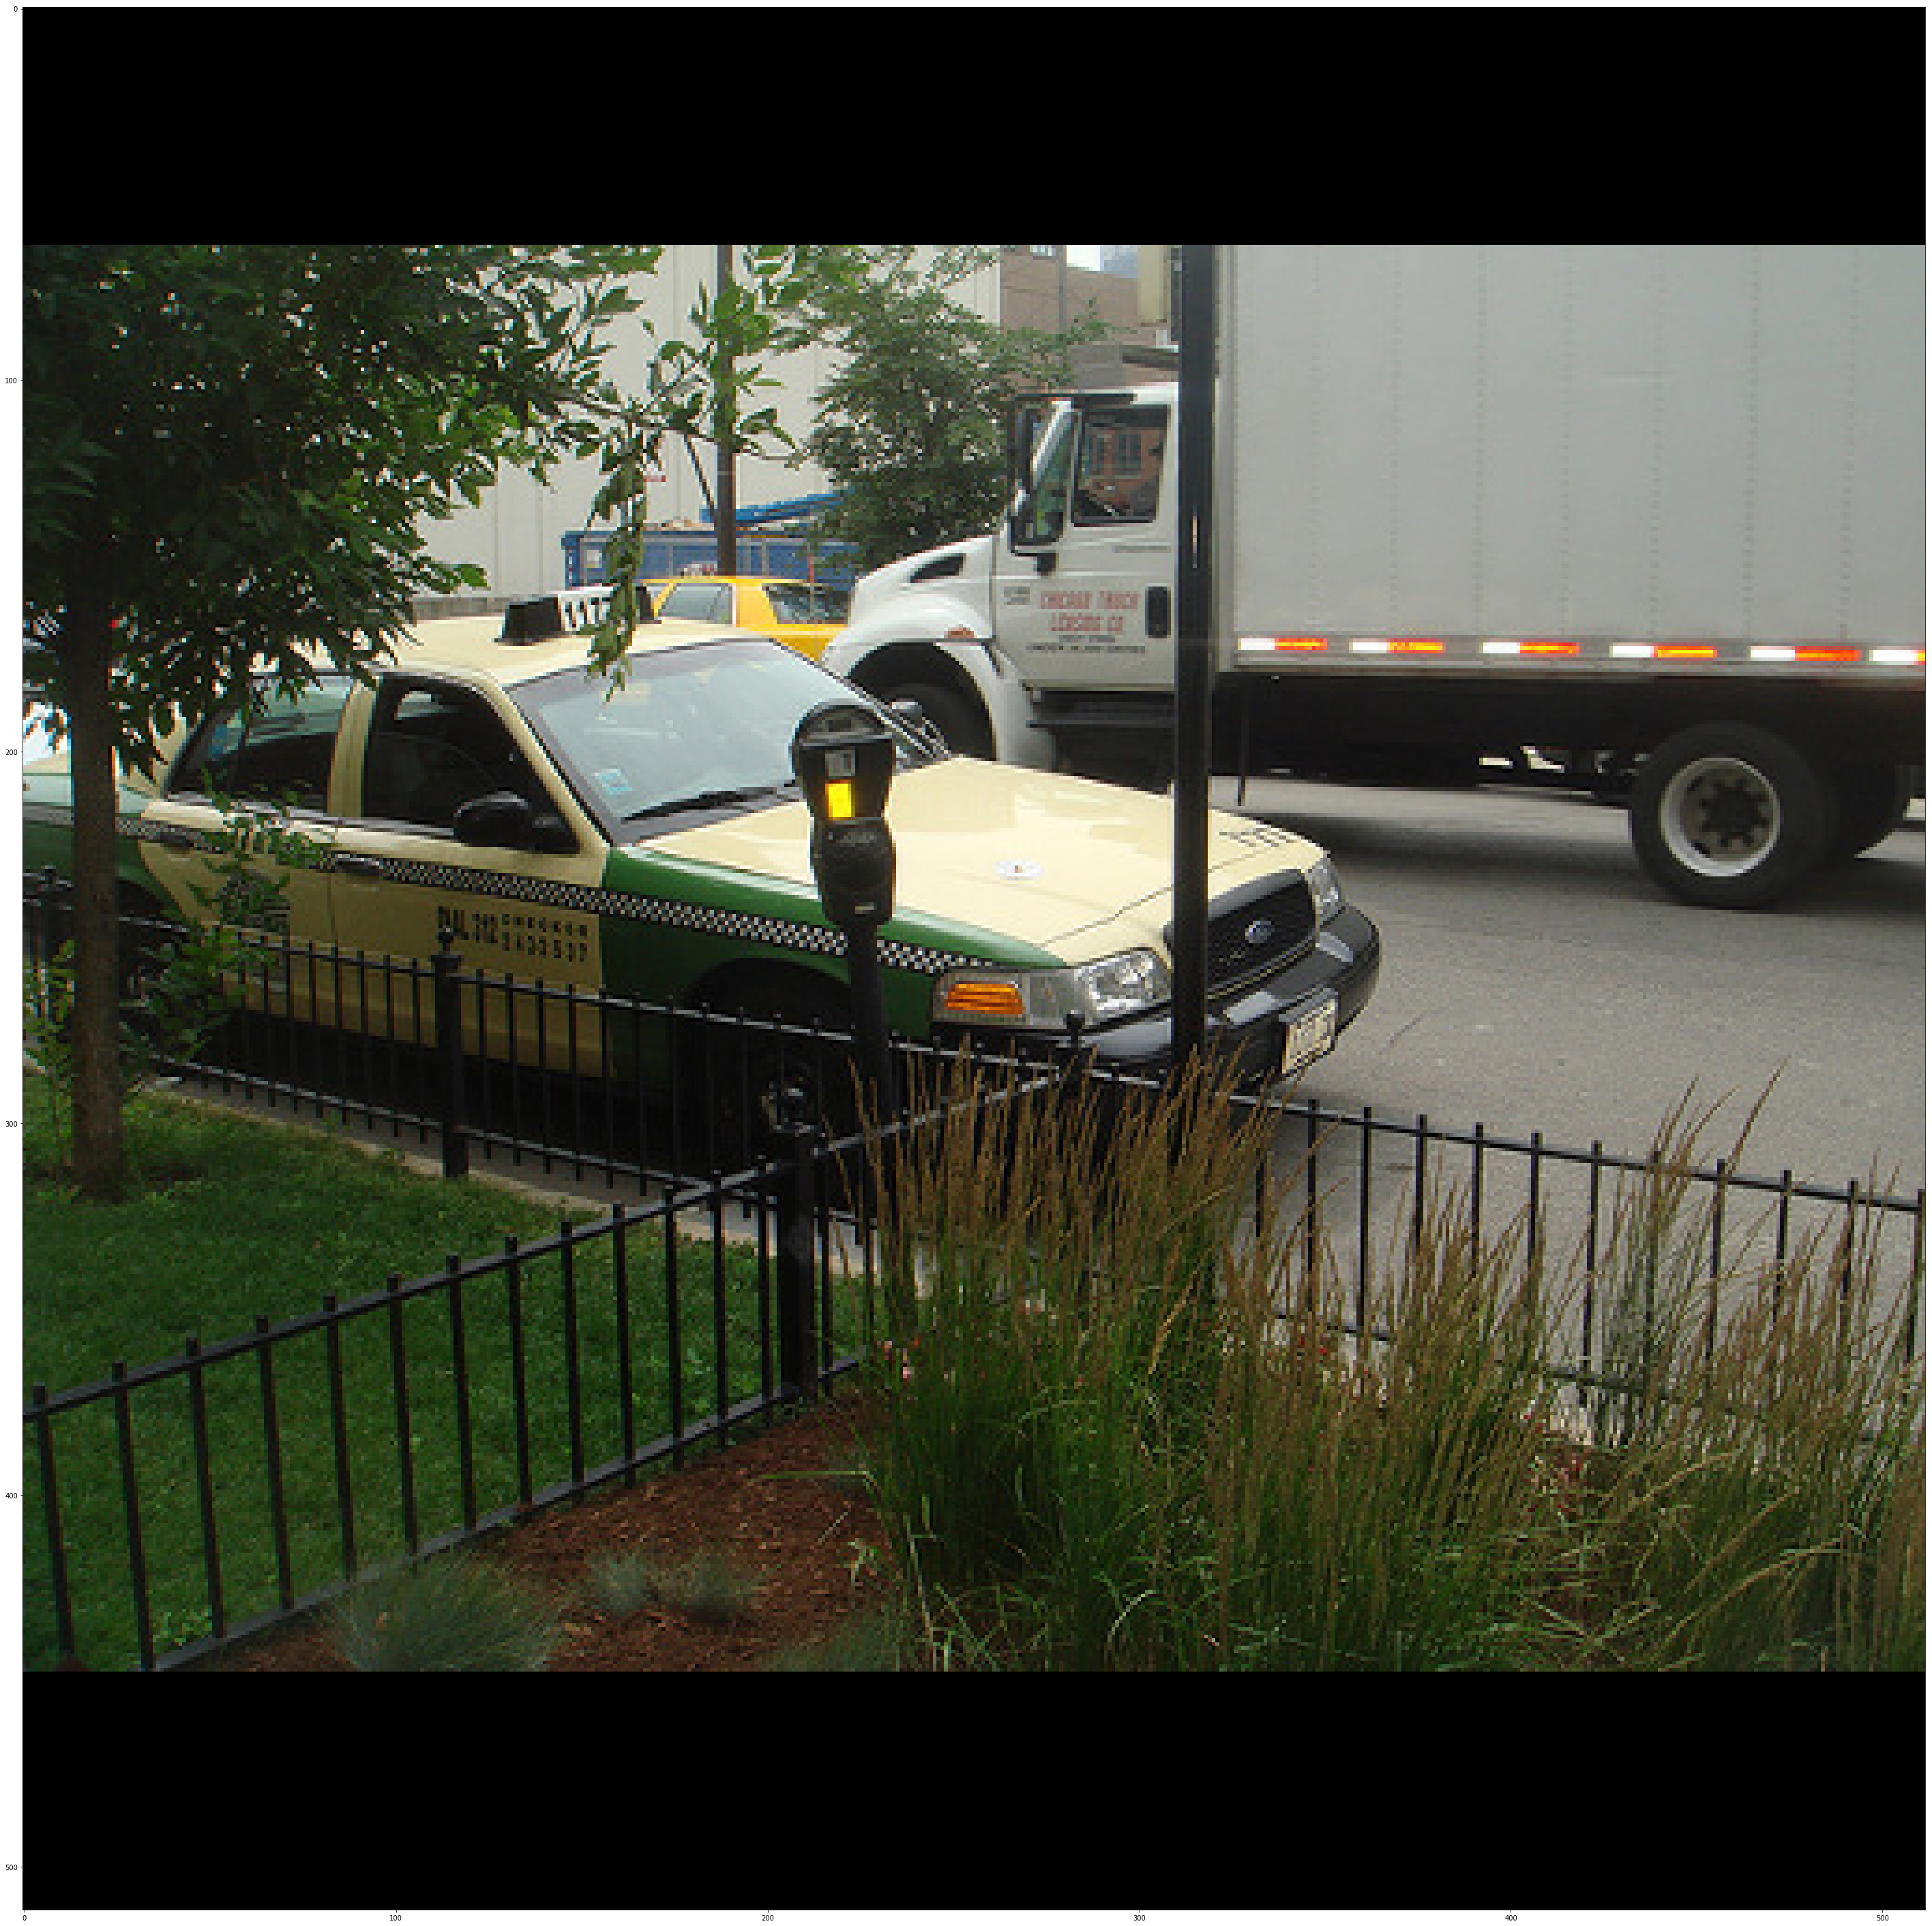

In [15]:
test = ex_train
print(test.shape)
test = resize_keep_aspect_ratio(test, (512,512))
test = preprocessing(test)
test = zero_padd(test, (512,512))
print(test.shape)
plt.figure(figsize = (50,100))
plt.imshow(((test + 1)*128).astype(np.uint8), cmap='gray', vmin=-1, vmax=1)